# Модель для предсказания уровня зарплатных ожиданий сотрудников

## Импорты

In [ ]:
!pip install catboost

In [46]:
# Вычисления и анализ
import numpy as np
import pandas as pd

# Хранение и загрузка постоянных данных
from google.colab import drive

# Визуализация данных
import seaborn as sns
from seaborn import heatmap
import matplotlib.pyplot as plt

# Утилиты и препроцессинг
import random
import warnings
from sklearn.utils import shuffle
from prettytable import PrettyTable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Модели и метрики
import sklearn
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error as mae

# Воспроизводимость и продакшн
import pickle

## Исходные данные

In [ ]:
drive.mount('/content/drive')
wdir = '/content/drive/My Drive/Courses/DataScience/DataScience/I_DIPLOMA/data'

In [ ]:
raw_data = pd.read_excel(f'{wdir}/raw_data.xlsx')

In [ ]:
raw_data.head(3)

,Unnamed: 0,entrydate,title,position,gender,city,age,salary,experience,last_job,updated,link
0,0,2020-04-08,"Резюме Менеджер по продажам мебели, дизайнер-к...",Менеджер по продажам,Женщина,Москва,31,70,8.0,ООО ИНТЕХ,2020-04-08,https://hh.ru/resume/840fd6300000a252640039ed1...
1,1,2020-04-08,Резюме Специалист по работе с клиентами,Клиентский менеджер,Мужчина,Липецк,40,90,15.0,МДК,2020-04-08,https://hh.ru/resume/66498670000716a4250039ed1...
2,2,2020-04-08,"Резюме Супервайзер торговых представителей, ст...",Супервайзер,Мужчина,Самара,34,50,7.0,Ютф-дистрибьютор,2020-04-08,https://hh.ru/resume/70e7817700035195b70039ed1...


In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3178 entries, 0 to 3177
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  3178 non-null   int64         
 1   entrydate   3178 non-null   datetime64[ns]
 2   title       3178 non-null   object        
 3   position    3178 non-null   object        
 4   gender      3178 non-null   object        
 5   city        3178 non-null   object        
 6   age         3178 non-null   int64         
 7   salary      3178 non-null   int64         
 8   experience  2522 non-null   float64       
 9   last_job    3178 non-null   object        
 10  updated     3178 non-null   datetime64[ns]
 11  link        3178 non-null   object        
dtypes: datetime64[ns](2), float64(1), int64(3), object(6)
memory usage: 298.1+ KB


In [ ]:
raw_data.columns

Index(['Unnamed: 0', 'entrydate', 'title', 'position', 'gender', 'city', 'age',
       'salary', 'experience', 'last_job', 'updated', 'link'],
      dtype='object')

## Предобработка данных

In [ ]:
def data_prep(df_input):
  """Обрабатывает исходные данные"""
  df_output = df_input.copy()
  df_output['experience'] = df_output['experience'].fillna(
                            df_output['experience'].mean())
  df_output['experience'] = df_output['experience'].astype(np.int)
  df_output.drop([
                  'Unnamed: 0',
                  'title',
                  'entrydate',
                  'last_job',
                  'updated',
                  'link'],
                 axis=1,
                 inplace=True)
  
  return df_output

In [ ]:
# Посмотрим на подготовленные данные
data = data_prep(raw_data)
data.head()

,position,gender,city,age,salary,experience
0,Менеджер по продажам,Женщина,Москва,31,70,8
1,Клиентский менеджер,Мужчина,Липецк,40,90,15
2,Супервайзер,Мужчина,Самара,34,50,7
3,Коммерческий директор,Мужчина,Краснодар,47,60,10
4,Менеджер по продажам,Мужчина,Москва,43,50,11


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3178 entries, 0 to 3177
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   position    3178 non-null   object
 1   gender      3178 non-null   object
 2   city        3178 non-null   object
 3   age         3178 non-null   int64 
 4   salary      3178 non-null   int64 
 5   experience  3178 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 149.1+ KB


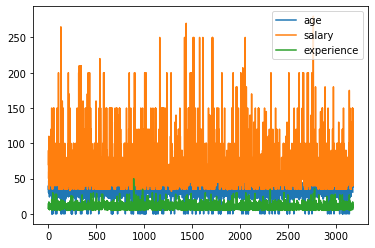

In [ ]:
# Посмотрим, есть ли в данных выбросы
data.plot();

In [ ]:
data[data['salary'] > 200]

,position,gender,city,age,salary,experience
130,Коммерческий директор,Мужчина,Москва,36,265,12
322,Менеджер по продажам,Мужчина,Москва,29,210,7
331,Менеджер по продажам,Мужчина,Москва,29,210,7
342,Менеджер по продажам,Мужчина,Москва,29,210,7
537,Региональный менеджер,Male,Moscow,35,220,10
1162,Менеджер по продажам,Мужчина,Москва,37,250,14
1421,Руководитель продаж,Мужчина,Москва,51,250,10
1429,Руководитель продаж,Мужчина,Москва,51,250,10
1438,Менеджер по продажам,Мужчина,Уфа,26,270,10
1511,Менеджер по продажам,Женщина,Москва,48,250,10


Пожалуй, все позиции кроме "Руководитель продаж" и "Коммерческий директор" с ожиданиями выше 200 тыс.руб - будут вносить "разлад" в наши данные. Удалим их

In [ ]:
 isx = data[
      (data['salary'] > 200) & 
      (data['position'] != 'Коммерческий директор') &
      (data['position'] != 'Руководитель продаж')].index

data = data.drop(data.index[isx])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3169 entries, 0 to 3177
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   position    3169 non-null   object
 1   gender      3169 non-null   object
 2   city        3169 non-null   object
 3   age         3169 non-null   int64 
 4   salary      3169 non-null   int64 
 5   experience  3169 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 173.3+ KB


## Feature engineering

Обогатим наши данные численностью населения в городах проживания кандидатов, источник данных: https://zema.su/blog/polnyi-spisok-vsekh-gorodov-rossii-po-chislennosti-naseleniya

In [ ]:
cities = pd.read_excel(f'{wdir}/cities.xlsx')
cities = cities.drop('Н', axis=1)
cities.columns = ['city', 'population']
cities.head()

,city,population
0,Москва,11514330
1,Санкт-Петербург,4848742
2,Новосибирск,1473737
3,Екатеринбург,1350136
4,Нижний Новгород,1250615


In [ ]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109 entries, 0 to 1108
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   city        1109 non-null   object
 1   population  1109 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 17.5+ KB


In [ ]:
# Добавим данные по численности к основному датасету
data_merged = data.merge(cities, how='left', left_on='city', right_on='city')
data_merged.head()

,position,gender,city,age,salary,experience,population
0,Менеджер по продажам,Женщина,Москва,31,70,8,11514330.0
1,Клиентский менеджер,Мужчина,Липецк,40,90,15,508124.0
2,Супервайзер,Мужчина,Самара,34,50,7,1164896.0
3,Коммерческий директор,Мужчина,Краснодар,47,60,10,744933.0
4,Менеджер по продажам,Мужчина,Москва,43,50,11,11514330.0


In [ ]:
# Посмотрим % пропусков в столбце "population"
empty_values = data_merged['population'].isna().sum() / len (data_merged) * 100
print(f'{round(empty_values, 2)}%')

6.69%


In [ ]:
# Пропуски есть, но не критично много
# заполним их средними значениями
data_merged['population'] = data_merged['population'].fillna(
                            data_merged['population'].mean())
# И преобразуем float к int
data_merged['population'] = data_merged['population'].astype(np.int)
data_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3169 entries, 0 to 3168
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   position    3169 non-null   object
 1   gender      3169 non-null   object
 2   city        3169 non-null   object
 3   age         3169 non-null   int64 
 4   salary      3169 non-null   int64 
 5   experience  3169 non-null   int64 
 6   population  3169 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 198.1+ KB


In [ ]:
data_merged.head()

,position,gender,city,age,salary,experience,population
0,Менеджер по продажам,Женщина,Москва,31,70,8,11514330
1,Клиентский менеджер,Мужчина,Липецк,40,90,15,508124
2,Супервайзер,Мужчина,Самара,34,50,7,1164896
3,Коммерческий директор,Мужчина,Краснодар,47,60,10,744933
4,Менеджер по продажам,Мужчина,Москва,43,50,11,11514330


In [ ]:
# Далее, преобразуем категориальные признаки в числовые
data_merged['gender_lbl'] = data_merged['gender'].apply(
                            lambda x: 1 if x == 'Мужчина' else 0
                            )
data_merged.head()

,position,gender,city,age,salary,experience,population,gender_lbl
0,Менеджер по продажам,Женщина,Москва,31,70,8,11514330,0
1,Клиентский менеджер,Мужчина,Липецк,40,90,15,508124,1
2,Супервайзер,Мужчина,Самара,34,50,7,1164896,1
3,Коммерческий директор,Мужчина,Краснодар,47,60,10,744933,1
4,Менеджер по продажам,Мужчина,Москва,43,50,11,11514330,1


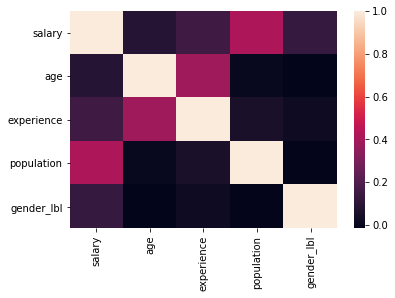

In [ ]:
# Посмотрим на зависимости между признаками
heatmap(
    data_merged[['salary', 
                 'age', 
                 'experience', 
                 'population', 
                 'gender_lbl']
                ].corr());

Как видно, самая сильная зависимость уровня ожиданий - от численности населения города проживания (в крупных городах ожидания явно выше)

In [ ]:
# Добавим фиктивные переменные к датасету из наименований позиций
# при помощи метода "One-hot encoding"
data_dummy = pd.get_dummies(data_merged.drop(['city', 'gender'], axis=1))
data_dummy.head()

,age,salary,experience,population,gender_lbl,position_Администратор,position_Водитель,position_Кам,position_Кассир,position_Кладовщик,position_Клиентский менеджер,position_Коммерческий директор,position_Курьер,position_Менеджер по закупкам,position_Менеджер по продажам,position_Менеджер по развитию,position_Мерчендайзер,position_Оператор,position_Помощник менеджера,position_Продавец-консультант,position_Региональный менеджер,position_Руководитель продаж,position_Специалист,position_Супервайзер,position_Территориальный менеджер,position_Товаровед,position_Торговый представитель,position_Управляющий магазином
0,31,70,8,11514330,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,40,90,15,508124,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,34,50,7,1164896,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,47,60,10,744933,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,43,50,11,11514330,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


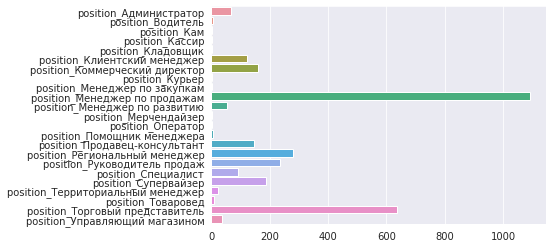

In [ ]:
# Посмотрим на частые позиции
db = data_dummy.drop(['age',	'salary',	'experience',	
                       'population',	'gender_lbl'], axis=1)

sns.barplot(x = db.sum(), 
            y = db.sum().index);

In [ ]:
# Как видно, данные по позициям очень неоднородны
# Случайным образом "перемешаем" и добавим частями
# уже имеющиеся данные в датасет

for i in range(30000):
  data_shuffle = shuffle(data_dummy).head(10)
  data_dummy = data_dummy.append(data_shuffle)

len(data_dummy)

303169

In [ ]:
# Теперь выберем по 400 случайных строк по каждой позиции

balanced_data = pd.DataFrame()

for i in data_dummy.columns[5:]:
  data_filtred = data_dummy[data_dummy[i] == 1].head(400)
  balanced_data = balanced_data.append(data_filtred)
  balanced_data.index = range(len(balanced_data.index))

In [ ]:
def transliterate(name):
   """
   Транслитерация наименований должностей
   """
   # Слоаврь с заменами
   slovar = {'а':'a','б':'b','в':'v','г':'g','д':'d','е':'e','ё':'e',
      'ж':'zh','з':'z','и':'i','й':'i','к':'k','л':'l','м':'m','н':'n',
      'о':'o','п':'p','р':'r','с':'s','т':'t','у':'u','ф':'f','х':'h',
      'ц':'c','ч':'cz','ш':'sh','щ':'scz','ъ':'','ы':'y','ь':'','э':'e',
      'ю':'u','я':'ja', 'А':'A','Б':'B','В':'V','Г':'G','Д':'D','Е':'E','Ё':'E',
      'Ж':'ZH','З':'Z','И':'I','Й':'I','К':'K','Л':'L','М':'M','Н':'N',
      'О':'O','П':'P','Р':'R','С':'S','Т':'T','У':'U','Ф':'F','Х':'H',
      'Ц':'C','Ч':'CZ','Ш':'SH','Щ':'SCH','Ъ':'','Ы':'y','Ь':'','Э':'E',
      'Ю':'U','Я':'YA',',':'','?':'',' ':'_','~':'','!':'','@':'','#':'',
      '$':'','%':'','^':'','&':'','*':'','(':'',')':'','-':'','=':'','+':'',
      ':':'',';':'','<':'','>':'','\'':'','"':'','\\':'','/':'','№':'',
      '[':'',']':'','{':'','}':'','ґ':'','ї':'', 'є':'','Ґ':'g','Ї':'i',
      'Є':'e', '—':''}
        
   # Циклически заменяем все буквы в строке
   for key in slovar:
      name = name.replace(key, slovar[key])
   return name

In [ ]:
# Заменим наименования на кирилице латиницей
new_names = []

for name in balanced_data.columns:
  new_name = transliterate(name)
  new_names.append(new_name)

print(new_names)

['age', 'salary', 'experience', 'population', 'gender_lbl', 'position_Administrator', 'position_Voditel', 'position_Kam', 'position_Kassir', 'position_Kladovsczik', 'position_Klientskii_menedzher', 'position_Kommerczeskii_direktor', 'position_Kurer', 'position_Menedzher_po_zakupkam', 'position_Menedzher_po_prodazham', 'position_Menedzher_po_razvitiu', 'position_Merczendaizer', 'position_Operator', 'position_Pomoscznik_menedzhera', 'position_Prodaveckonsultant', 'position_Regionalnyi_menedzher', 'position_Rukovoditel_prodazh', 'position_Specialist', 'position_Supervaizer', 'position_Territorialnyi_menedzher', 'position_Tovaroved', 'position_Torgovyi_predstavitel', 'position_Upravljausczii_magazinom']


In [ ]:
balanced_data.columns = new_names
balanced_data.head()

,age,salary,experience,population,gender_lbl,position_Administrator,position_Voditel,position_Kam,position_Kassir,position_Kladovsczik,position_Klientskii_menedzher,position_Kommerczeskii_direktor,position_Kurer,position_Menedzher_po_zakupkam,position_Menedzher_po_prodazham,position_Menedzher_po_razvitiu,position_Merczendaizer,position_Operator,position_Pomoscznik_menedzhera,position_Prodaveckonsultant,position_Regionalnyi_menedzher,position_Rukovoditel_prodazh,position_Specialist,position_Supervaizer,position_Territorialnyi_menedzher,position_Tovaroved,position_Torgovyi_predstavitel,position_Upravljausczii_magazinom
0,31,60,8,11514330,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,31,60,8,11514330,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,29,50,7,11514330,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,29,50,7,11514330,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,33,55,12,11514330,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Сохраним подготовленные данные
balanced_data.to_excel(f'{wdir}/balanced_data.xlsx')

In [5]:
# Загрузим подготовленные данные
balanced_data = pd.read_excel(f'{wdir}/balanced_data.xlsx')
balanced_data = balanced_data.drop('Unnamed: 0', axis=1)
balanced_data = shuffle(balanced_data, random_state=42)
balanced_data.head()

,age,salary,experience,population,gender_lbl,position_Administrator,position_Voditel,position_Kam,position_Kassir,position_Kladovsczik,position_Klientskii_menedzher,position_Kommerczeskii_direktor,position_Kurer,position_Menedzher_po_zakupkam,position_Menedzher_po_prodazham,position_Menedzher_po_razvitiu,position_Merczendaizer,position_Operator,position_Pomoscznik_menedzhera,position_Prodaveckonsultant,position_Regionalnyi_menedzher,position_Rukovoditel_prodazh,position_Specialist,position_Supervaizer,position_Territorialnyi_menedzher,position_Tovaroved,position_Torgovyi_predstavitel,position_Upravljausczii_magazinom
7203,34,80,16,11514330,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5057,29,65,9,592069,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6338,27,70,7,1143546,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
132,30,35,7,312311,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4078,32,50,5,4394741,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
balanced_data.describe()

,age,salary,experience,population,gender_lbl,position_Administrator,position_Voditel,position_Kam,position_Kassir,position_Kladovsczik,position_Klientskii_menedzher,position_Kommerczeskii_direktor,position_Kurer,position_Menedzher_po_zakupkam,position_Menedzher_po_prodazham,position_Menedzher_po_razvitiu,position_Merczendaizer,position_Operator,position_Pomoscznik_menedzhera,position_Prodaveckonsultant,position_Regionalnyi_menedzher,position_Rukovoditel_prodazh,position_Specialist,position_Supervaizer,position_Territorialnyi_menedzher,position_Tovaroved,position_Torgovyi_predstavitel,position_Upravljausczii_magazinom
count,7614.0000,7614.000000,7614.000000,7.614000e+03,7614.000000,7614.000000,7614.000000,7614.000000,7614.000000,7614.000000,7614.000000,7614.000000,7614.000000,7614.000000,7614.000000,7614.000000,7614.000000,7614.000000,7614.000000,7614.000000,7614.000000,7614.000000,7614.000000,7614.000000,7614.000000,7614.000000,7614.000000,7614.000000
mean,32.2171,62.688337,10.551090,5.834563e+06,0.667061,0.052535,0.052535,0.011295,0.028631,0.052535,0.052535,0.052535,0.000657,0.017599,0.052535,0.052535,0.035330,0.013396,0.052535,0.052535,0.052535,0.052535,0.052535,0.052535,0.052535,0.052535,0.052535,0.052535
std,11.0929,34.202136,4.589487,4.966777e+06,0.471296,0.223118,0.223118,0.105683,0.166779,0.223118,0.223118,0.223118,0.025619,0.131498,0.223118,0.223118,0.184624,0.114972,0.223118,0.223118,0.223118,0.223118,0.223118,0.223118,0.223118,0.223118,0.223118,0.223118
min,0.0000,32.000000,5.000000,1.184800e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.0000,40.000000,7.000000,8.378310e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33.0000,50.000000,10.000000,4.848742e+06,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,39.0000,70.000000,12.000000,1.151433e+07,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,72.0000,280.000000,50.000000,1.151433e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7614 entries, 7203 to 7270
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   age                                7614 non-null   int64
 1   salary                             7614 non-null   int64
 2   experience                         7614 non-null   int64
 3   population                         7614 non-null   int64
 4   gender_lbl                         7614 non-null   int64
 5   position_Administrator             7614 non-null   int64
 6   position_Voditel                   7614 non-null   int64
 7   position_Kam                       7614 non-null   int64
 8   position_Kassir                    7614 non-null   int64
 9   position_Kladovsczik               7614 non-null   int64
 10  position_Klientskii_menedzher      7614 non-null   int64
 11  position_Kommerczeskii_direktor    7614 non-null   int64
 12  position_Kurer   

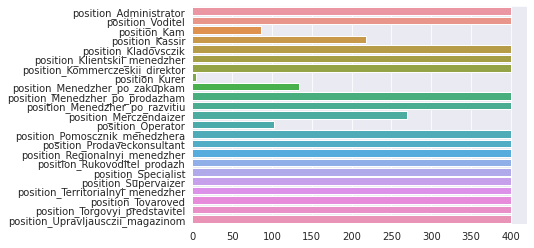

In [ ]:
# Снова посмотрим на позиции
db = balanced_data.drop(['age',	'salary',	'experience',	
                       'population',	'gender_lbl'], axis=1)

sns.barplot(x = db.sum(), 
            y = db.sum().index);

In [ ]:
balanced_data.columns

Index(['age', 'salary', 'experience', 'population', 'gender_lbl',
       'position_Administrator', 'position_Voditel', 'position_Kam',
       'position_Kassir', 'position_Kladovsczik',
       'position_Klientskii_menedzher', 'position_Kommerczeskii_direktor',
       'position_Kurer', 'position_Menedzher_po_zakupkam',
       'position_Menedzher_po_prodazham', 'position_Menedzher_po_razvitiu',
       'position_Merczendaizer', 'position_Operator',
       'position_Pomoscznik_menedzhera', 'position_Prodaveckonsultant',
       'position_Regionalnyi_menedzher', 'position_Rukovoditel_prodazh',
       'position_Specialist', 'position_Supervaizer',
       'position_Territorialnyi_menedzher', 'position_Tovaroved',
       'position_Torgovyi_predstavitel', 'position_Upravljausczii_magazinom'],
      dtype='object')

Совсем другое дело...

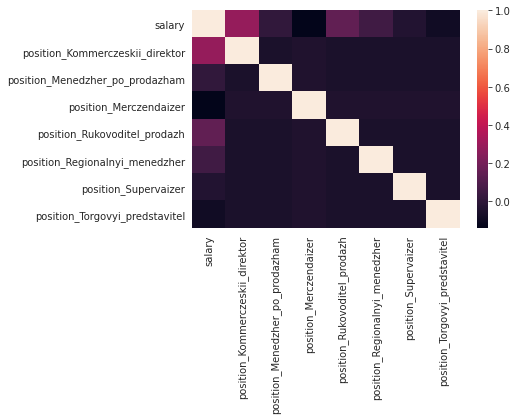

In [ ]:
heatmap(balanced_data[['salary',
                   'position_Kommerczeskii_direktor',
                   'position_Menedzher_po_prodazham',
                   'position_Merczendaizer',
                   'position_Rukovoditel_prodazh',
                   'position_Regionalnyi_menedzher',
                   'position_Supervaizer',
                   'position_Torgovyi_predstavitel'
                    ]].corr());

Также на примере мы видим явную зависимость между статусными позициями, такими как "Коммерческий директор" и "Руководитель продаж" и уровнем их ожиданий по доходу

## Baseline - тренируем наивную модель

"Always start with a stupid model, no exceptions..."

In [6]:
# Фиксируем гиперпараметры
random_seed = 42
splits = 5

In [11]:
def data_split(data):
  """Hold-out разбиение датасета на выборки
  для последующего использования в моделях"""
  X = data.drop(['salary'], axis=1)
  y = data['salary'].values

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, shuffle=True,
      random_state=random_seed)
  
  return X_train, X_test, y_train, y_test

In [ ]:
# Посмотрим на структуру разбиения
x = PrettyTable()

X_train, X_test, y_train, y_test = data_split(balanced_data)

x.field_names = ["Тип выборки", "Размерность"]
x.add_row(["Исходная выборка", balanced_data.shape])
x.add_row(["X_train", X_train.shape])
x.add_row(["X_test", X_test.shape])
x.add_row(["y_train", y_train.shape])
x.add_row(["y_test", y_test.shape])
print(x)

+------------------+-------------+
|   Тип выборки    | Размерность |
+------------------+-------------+
| Исходная выборка |  (7614, 28) |
|     X_train      |  (6091, 27) |
|      X_test      |  (1523, 27) |
|     y_train      |   (6091,)   |
|      y_test      |   (1523,)   |
+------------------+-------------+


Для baseline будем использовать простейшее предсказание на основе средний значений salary по каждой позиции

In [ ]:
balanced_data.columns

Index(['age', 'salary', 'experience', 'population', 'gender_lbl',
       'position_Administrator', 'position_Voditel', 'position_Kam',
       'position_Kassir', 'position_Kladovsczik',
       'position_Klientskii_menedzher', 'position_Kommerczeskii_direktor',
       'position_Kurer', 'position_Menedzher_po_zakupkam',
       'position_Menedzher_po_prodazham', 'position_Menedzher_po_razvitiu',
       'position_Merczendaizer', 'position_Operator',
       'position_Pomoscznik_menedzhera', 'position_Prodaveckonsultant',
       'position_Regionalnyi_menedzher', 'position_Rukovoditel_prodazh',
       'position_Specialist', 'position_Supervaizer',
       'position_Territorialnyi_menedzher', 'position_Tovaroved',
       'position_Torgovyi_predstavitel', 'position_Upravljausczii_magazinom'],
      dtype='object')

In [ ]:
def baseline(data):
  """Базовая модель на основе предсказания среднего 
  значения по признакам: возраст, пол, опыт, город"""
  X_train, X_test, y_train, y_test = data_split(data)
  X_train['salary'] = y_train
  y = data['salary'].values

  predict = []

  for index, row in pd.DataFrame(X_test).iterrows():
    results = X_train.query(f'age == {row[0]} \
                            and experience == {row[1]} \
                            and population == {row[2]} \
                            and gender_lbl == {row[3]} \
                            ')['salary'].mean()
    predict.append(results)
  

  predict = pd.DataFrame(predict)
  predict = predict.fillna(predict.mean())
  error = mae(y_test, predict)

  print('MAE:', error, 'MAPE:', error / data['salary'].mean())

  fig, ax = plt.subplots()
  ax.scatter(y_test, predict, edgecolors=(0,0,0))
  ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
  ax.set_xlabel('Measured')
  ax.set_ylabel('Predicted')
  plt.show()

MAE: 5.69881568553126 MAPE: 0.09090711180730934


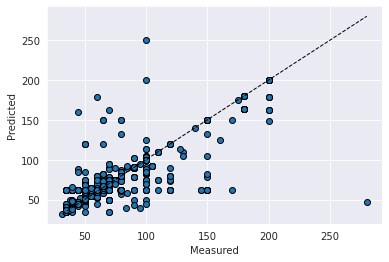

In [ ]:
baseline(balanced_data)

In [ ]:
def baseline2(data):
  """Базовая модель на основе предсказания среднего 
  значения по признакам: должность, город"""
  cat_data = data.iloc[:, :5]
  # Реверсия категориальных признаков для простоты работы с данными
  cat_data['position'] = pd.get_dummies(data.iloc[:, 5:]).idxmax(1)
  # Разбиение выборки
  X_train, X_test, y_train, y_test = data_split(cat_data)
  X_train['salary'] = y_train
  y = data['salary'].values

  predict = []

  for index, row in pd.DataFrame(X_test).iterrows():
    results = X_train.query(f'population == {row[2]} \
                            and position == "{row[4]}" \
                            ')['salary'].mean()
    predict.append(results)
  

  predict = pd.DataFrame(predict)
  predict = predict.fillna(predict.mean())
  error = mae(y_test, predict)

  print('MAE:', error, 'MAPE:', error / data['salary'].mean())

  fig, ax = plt.subplots()
  ax.scatter(y_test, predict, edgecolors=(0,0,0))
  ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
  ax.set_xlabel('Measured')
  ax.set_ylabel('Predicted')
  plt.show()

MAE: 9.28897246759676 MAPE: 0.14817704331634587


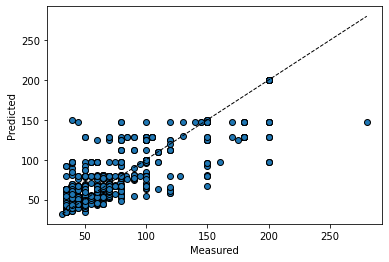

In [ ]:
warnings.filterwarnings('ignore')
baseline2(balanced_data)

In [ ]:
def baseline3(data):
  """Базовая модель на основе предсказания среднего 
  значения по признакам: все признаки"""
  cat_data = data.iloc[:, :5]
  # Реверсия категориальных признаков для простоты работы с данными
  cat_data['position'] = pd.get_dummies(data.iloc[:, 5:]).idxmax(1)
  # Разбиение выборки
  X_train, X_test, y_train, y_test = data_split(cat_data)
  X_train['salary'] = y_train
  y = data['salary'].values

  predict = []

  for index, row in pd.DataFrame(X_test).iterrows():
    results = X_train.query(f'age == {row[0]} \
                            and experience == {row[1]} \
                            and population == {row[2]} \
                            and gender_lbl == {row[3]} \
                            and position == "{row[4]}" \
                            ')['salary'].mean()
    predict.append(results)
  

  predict = pd.DataFrame(predict)
  predict = predict.fillna(predict.mean())
  error = mae(y_test, predict)

  print('MAE:', error, 'MAPE:', error / data['salary'].mean())

  fig, ax = plt.subplots()
  ax.scatter(y_test, predict, edgecolors=(0,0,0))
  ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
  ax.set_xlabel('Measured')
  ax.set_ylabel('Predicted')
  plt.show()


MAE: 3.423671696230681 MAPE: 0.05461417298877751


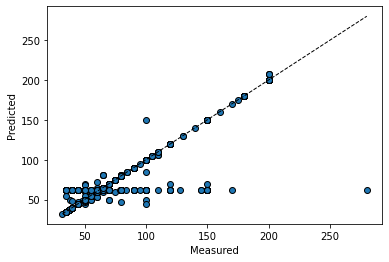

In [ ]:
# Усреднение по всем признакам датасета
baseline3(balanced_data)

Метрики `mae` и `mape` выберем в связи с их высокой интуитивностью, ведь все понимают, что ошибка модели в 1-2 тыс.р - приемлемый результат, а в 5-10 тыс.р при средней ожидаемой зарплате в 65 тыс.р. - это достаточно много.

## Подготовка и построение модели

### Разбиение выборки и кросс-валидация

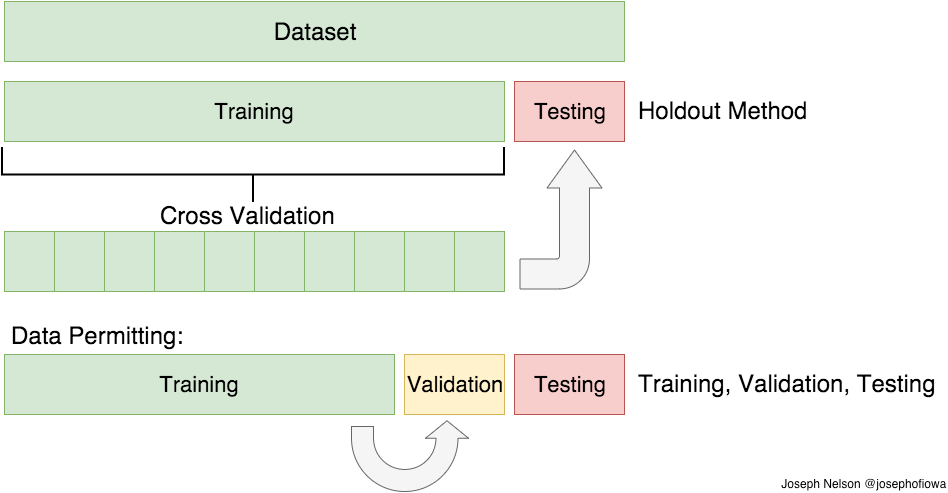

Обучение модели на одной разбивке данных, особенно при небольшом их количестве, как в нашем случае - является методологической ошибкой. Поэтому, сделаем разбиение данных на фолды и кросс-валидацию

In [ ]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [ ]:
def cross_val(data, model):
  """Скоринг кросс-валидации данных"""
  X = data.drop(['salary'], axis=1)
  y = data['salary'].values

  cv_score = cross_val_score(model, 
                              X, y, 
                              cv=splits,
                              scoring='neg_mean_absolute_error',
                              n_jobs=-1)
  return abs(cv_score.mean())

In [ ]:
# Начнем с модели линейной регрессии
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()
cross_val(balanced_data, model_lr)

14.861915950785377

In [ ]:
def cross_val_fig(data, model):
  """Визуализация прогноза кросс-валидации данных"""
  X = data.drop(['salary'], axis=1)
  y = data['salary'].values

  predicted = cross_val_predict(model, 
                                X, y, 
                                cv=splits)
  
  error = mae(y, predicted)
  # cross_val_predict возвращает массив размерности `y`, где каждое значение
  # где каждый прогноз получен методом кросс-валидации:
  
  fig, ax = plt.subplots()
  for color in ['tab:orange', 'tab:green']:
    ax.scatter(y, predicted, edgecolors=(0,0,0), c=color)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
  
  print('MAE:', error, 'MAPE:', error / data['salary'].mean())
  plt.show()

MAE: 14.861858984014589 MAPE: 0.2370753417687223


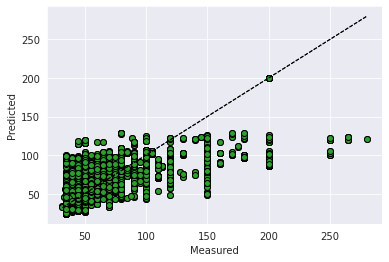

In [ ]:
model_lr = LinearRegression()
cross_val_fig(balanced_data, model_lr)

На графике видно, что модель недообучается, то есть, аппроксимирующей способности модели линейной регрессии недостаточно, чтобы описать зависимости в данных. Результат хуже Baseline. Требуется усложнение модели

### Сравнительное тестирование различных моделей с базовыми параметрами

In [ ]:
def review_models(data):
  """Обзор метрики MAE / MAPE некоторых моделей на
  стандартных настройках"""

  mean_salary = data['salary'].mean()

  X_train, X_test, y_train, y_test = data_split(data)
  
  # CatBoost
  model_catboost = CatBoostRegressor(random_state=random_seed)
  model_catboost.fit(X_train, y_train, silent=True)
  y_catboost = model_catboost.predict(X_test)
  mae_catboost = mae(y_test, y_catboost)

  # Lightgbm
  model_lightgbm = LGBMRegressor(random_state=random_seed)
  model_lightgbm.fit(X_train, y_train)
  y_lightgbm = model_lightgbm.predict(X_test)
  mae_lightgbm = mae(y_test, y_lightgbm)

  # XGBRegressor
  model_xgb = XGBRegressor(random_state=random_seed)
  model_xgb.fit(X_train, y_train)
  y_xgb = model_xgb.predict(X_test)
  mae_xgb = mae(y_test, y_xgb)

  # RandomForest
  model_rf = RandomForestRegressor(random_state=random_seed)
  model_rf.fit(X_train, y_train)
  y_rf = model_rf.predict(X_test)
  mae_rf = mae(y_test, y_rf)

  #ExtraTrees
  model_etr = ExtraTreesRegressor(random_state=random_seed)
  model_etr.fit(X_train, y_train)
  y_etr = model_etr.predict(X_test)
  mae_etr = mae(y_test, y_etr)
  
  # Таблица итогового сравнения
  x = PrettyTable()
  x.field_names = ["Regressor", "MAE", "MAPE"]
  x.add_row(["CatBoost", mae_catboost, mae_catboost / mean_salary])
  x.add_row(["LGBM", mae_lightgbm, mae_lightgbm / mean_salary])
  x.add_row(["RandomForest", mae_rf, mae_rf / mean_salary])
  x.add_row(["XGBoost", mae_xgb, mae_xgb / mean_salary])
  x.add_row(["ExtraTrees", mae_etr, mae_etr / mean_salary])

  print(x.get_string(sortby="MAPE"))


In [ ]:
# Обзор результатов
warnings.filterwarnings('ignore')
review_models(balanced_data)

[04:51:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
+--------------+--------------------+---------------------+
|  Regressor   |        MAE         |         MAPE        |
+--------------+--------------------+---------------------+
|  ExtraTrees  | 2.8997435356283034 | 0.04625650737839408 |
| RandomForest | 3.675666721421062  | 0.05863398011958703 |
|   CatBoost   | 6.351723300156864  |  0.1013222487055437 |
|     LGBM     | 7.145986001595396  | 0.11399227212591287 |
|   XGBoost    | 10.691318339136815 |  0.1705471672107329 |
+--------------+--------------------+---------------------+


Модель ExtraTreesRegressor из библиотеки sklearn показывает лучший стартовый  результат. Данный алгоритм использует метаоценщик и усреднение решений деревьев, что позволяет одновременно снизить риск переобучения модели, но при этом усложнить решение

In [27]:
# Посмотрим на значимость признаков для модели


def feature_importance(data):  
  """Оценка значимости признаков"""

  X_train, X_test, y_train, y_test = data_split(data)

  #ExtraTrees
  model_etr = ExtraTreesRegressor(random_state=random_seed)
  model_etr.fit(X_train, y_train)

  # Значения признаков
  r = permutation_importance(model_etr, 
                            X_test, y_test,
                            n_repeats=3,
                            random_state=random_seed)

  for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
      print(f"{data.columns[i]:<8}",
            f"{r.importances_mean[i]:.3f}",
            f" +/- {r.importances_std[i]:.3f}")

In [28]:
feature_importance(balanced_data)

experience 0.745  +/- 0.025
position_Klientskii_menedzher 0.448  +/- 0.031
position_Voditel 0.445  +/- 0.005
position_Menedzher_po_prodazham 0.291  +/- 0.028
age      0.247  +/- 0.009
population 0.208  +/- 0.008
salary   0.173  +/- 0.009
position_Kladovsczik 0.160  +/- 0.036
position_Regionalnyi_menedzher 0.150  +/- 0.012
position_Prodaveckonsultant 0.108  +/- 0.006
position_Supervaizer 0.046  +/- 0.001
position_Torgovyi_predstavitel 0.041  +/- 0.004
position_Operator 0.028  +/- 0.002
position_Kurer 0.027  +/- 0.001
position_Specialist 0.020  +/- 0.000
position_Rukovoditel_prodazh 0.017  +/- 0.003
position_Menedzher_po_zakupkam 0.017  +/- 0.001
position_Menedzher_po_razvitiu 0.007  +/- 0.001
gender_lbl 0.006  +/- 0.001
position_Pomoscznik_menedzhera 0.006  +/- 0.000
position_Administrator 0.001  +/- 0.000
position_Tovaroved 0.001  +/- 0.000
position_Kassir 0.001  +/- 0.000
position_Territorialnyi_menedzher 0.001  +/- 0.000
position_Kommerczeskii_direktor 0.000  +/- 0.000
position_Kam 0

### Обучение модели ExtraTreesRegressor с оптимизацией гиперпараметров

#### Оптимизация гиперпараметров

In [29]:
# GridSearchCV обладает встроенными метриками и позволяет
# осуществлять кросс-валидацию


def train_extra_trees(data):
  """Обучает модель регрессии ExtraTrees"""
  
  mean_salary = data['salary'].mean()
  X = data.drop(['salary'], axis=1)
  y = data['salary'].values
  X_train, X_test, y_train, y_test = data_split(data)
  
  # Описание модели
  model = ExtraTreesRegressor(random_state=random_seed)
  
  # Оптимизатор гиперпараметров
  params = {
      # 'criterion': ['mae', 'mse'],
      'n_estimators': [20, 30, 50, 100, 250],
      # 'min_samples_split': [1, 2, 4, 6, 8],
      'min_samples_leaf': [1, 2, 4, 6, 8],
      # 'min_weight_fraction_leaf': [0.0, 0.1],
      # 'min_impurity_decrease': [0.0, 0.1],
      # 'min_impurity_split': [0.0, 0.1],
      # 'bootstrap': ['True', 'False'],
      # 'ccp_alpha': [0.0, 0.1]
      }

  clf = GridSearchCV(model, 
                     params) # Кросс-валидация на n-folds
  
  search = clf.fit(X, y)
  best_params = search.best_params_
  print('Лучшие параметры:', best_params)
  print('Обучение модели на лучших параметрах...')

  # Обучение модели с оптимальными гиперпараметрами
  best_model = ExtraTreesRegressor(
      random_state=random_seed,
      criterion='mae',
      # n_estimators=250,
      n_estimators=best_params['n_estimators'],
      # min_samples_split=best_params['min_samples_split'],
      min_samples_leaf=best_params['min_samples_leaf'],
      # min_weight_fraction_leaf=best_params['min_weight_fraction_leaf'],
      # min_impurity_decrease=best_params['min_impurity_decrease'],
      # min_impurity_split=best_params['min_impurity_split'],
      # bootstrap=best_params['bootstrap'],
      # ccp_alpha=best_params['ccp_alpha'],
      n_jobs=-1)
  
  best_model.fit(X_train, y_train)
  
  # Предсказание на основании обученной модели
  y_pred = best_model.predict(X_test)

  # Метрика качества mse
  error = mae(y_test, y_pred)
  
  print('MAE:', error, 'MAPE:', error / mean_salary)

  fig, ax = plt.subplots()
  for color in ['tab:orange', 'tab:green']:
    ax.scatter(y_test, y_pred, edgecolors=(0,0,0), c=color)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
  plt.show()

  return best_model

Лучшие параметры: {'min_samples_leaf': 1, 'n_estimators': 50}
Обучение модели на лучших параметрах...
MAE: 3.4707222586999342 MAPE: 0.055364720291763404


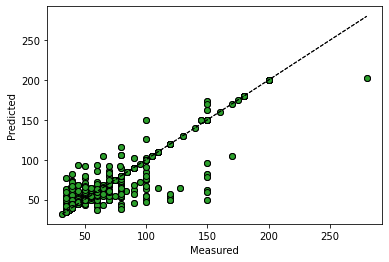

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mae',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=50, n_jobs=-1, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)

In [30]:
train_extra_trees(balanced_data)

Посмотрим на результаты модели, которая занимает второе место в предварительном тестировании

### Обучение модели RandomForestRegressor с оптимизацией гиперпараметров

Для сравнения с ExtraTreesRegression

#### Оптимизация гиперпараметров

In [ ]:
def train_random_forest(data):
  """Обучает модель регрессии ExtraTrees"""
  
  mean_salary = data['salary'].mean()
  X = data.drop(['salary'], axis=1)
  y = data['salary'].values
  X_train, X_test, y_train, y_test = data_split(data)
  
  # Описание модели
  model = RandomForestRegressor(random_state=random_seed)
  
  # Оптимизатор гиперпараметров
  params = {
      # 'criterion': ['mae', 'mse'],
      'n_estimators': [20, 30, 50, 100, 250],
      # 'min_samples_split': [1, 2, 4, 6, 8],
      # 'min_samples_leaf': [1, 2, 4, 6, 8],
      # 'min_weight_fraction_leaf': [0.0, 0.1],
      # 'min_impurity_decrease': [0.0, 0.1],
      # 'min_impurity_split': [0.0, 0.1],
      # 'bootstrap': ['True', 'False'],
      # 'ccp_alpha': [0.0, 0.1]
      }

  clf = GridSearchCV(model, params)
  
  search = clf.fit(X, y)
  best_params = search.best_params_
  print('Лучшие параметры:', best_params)
  print('Обучение модели на лучших параметрах...')

  # Обучение модели с оптимальными гиперпараметрами
  best_model = RandomForestRegressor(
      random_state=random_seed,
      criterion='mae',
      n_estimators=best_params['n_estimators'],
      # min_samples_split=best_params['min_samples_split'],
      # min_samples_leaf=best_params['min_samples_leaf'],
      # min_weight_fraction_leaf=best_params['min_weight_fraction_leaf'],
      # min_impurity_decrease=best_params['min_impurity_decrease'],
      # min_impurity_split=best_params['min_impurity_split'],
      # bootstrap=best_params['bootstrap'],
      # ccp_alpha=best_params['ccp_alpha'],
      n_jobs=-1)
  
  best_model.fit(X_train, y_train)
  
  # Предсказание на основании обученной модели
  y_pred = best_model.predict(X_test)

  # Метрика качества mse
  error = mae(y_test, y_pred)
  print('MAE:', error, 'MAPE:', error / mean_salary)

  fig, ax = plt.subplots()
  for color in ['tab:orange', 'tab:green']:
    ax.scatter(y_test, y_pred, edgecolors=(0,0,0), c=color)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
  plt.show()
  
  return best_model

Лучшие параметры: {'n_estimators': 250}
Обучение модели на лучших параметрах...
MAE: 3.8937373604727514 MAPE: 0.06211262780010335


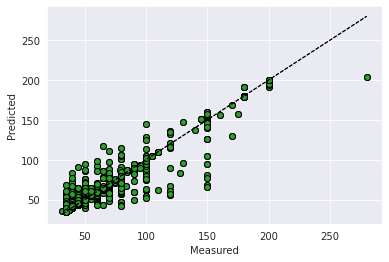

In [ ]:
best_model_rf = train_random_forest(balanced_data)

Variance и Bias у модели RandomForest видимо хуже, чем у ExtraTreesRegressor и хуже Baseline


## Построение признаков

Попробуем добавить в датасет новые данные на основе уже существующих, которые смогут привнести в наши данные новые зависимости

In [42]:
new_data = balanced_data.copy()

In [44]:
# Логарифмируем таргет для смягчения выбросов
new_data['salary'] = new_data['salary'].apply(lambda x: np.log(x))
new_data.head()

,age,salary,experience,population,gender_lbl,position_Administrator,position_Voditel,position_Kam,position_Kassir,position_Kladovsczik,position_Klientskii_menedzher,position_Kommerczeskii_direktor,position_Kurer,position_Menedzher_po_zakupkam,position_Menedzher_po_prodazham,position_Menedzher_po_razvitiu,position_Merczendaizer,position_Operator,position_Pomoscznik_menedzhera,position_Prodaveckonsultant,position_Regionalnyi_menedzher,position_Rukovoditel_prodazh,position_Specialist,position_Supervaizer,position_Territorialnyi_menedzher,position_Tovaroved,position_Torgovyi_predstavitel,position_Upravljausczii_magazinom
7203,34,4.382027,16,11514330,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5057,29,4.174387,9,592069,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6338,27,4.248495,7,1143546,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
132,30,3.555348,7,312311,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4078,32,3.912023,5,4394741,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


Лучшие параметры: {'min_samples_leaf': 1, 'n_estimators': 250}
Обучение модели на лучших параметрах...
MAE: 0.04169975555889976 MAPE: 0.010321550376585158


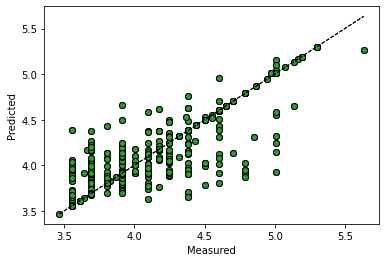

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mae',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=250, n_jobs=-1, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)

In [45]:
train_extra_trees(new_data)

In [55]:
# Создание полиномиальных признаков
poly_data = balanced_data.copy()
X = poly_data.drop(['salary'], axis=1)
y = poly_data['salary'].values

polynomial_features= PolynomialFeatures(degree=2)
X_poly = polynomial_features.fit_transform(X)
poly_data = pd.DataFrame(X_poly)
poly_data['salary'] = y

In [56]:
poly_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,salary
0,1.0,34.0,16.0,11514330.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1156.0,544.0,391487220.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,80
1,1.0,29.0,9.0,592069.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,841.0,261.0,17170001.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65
2,1.0,27.0,7.0,1143546.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,729.0,189.0,30875742.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70
3,1.0,30.0,7.0,312311.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,900.0,210.0,9369330.0,30.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35
4,1.0,32.0,5.0,4394741.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1024.0,160.0,140631712.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50


Лучшие параметры: {'min_samples_leaf': 1, 'n_estimators': 250}
Обучение модели на лучших параметрах...
MAE: 3.045336835193697 MAPE: 0.0485790015758446


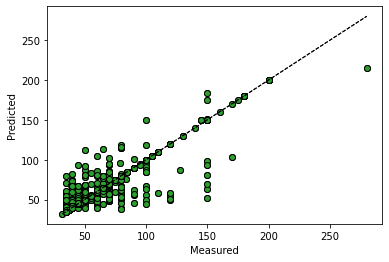

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mae',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=250, n_jobs=-1, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)

In [57]:
train_extra_trees(poly_data)

Наилучший результат получаем при логарифмировании таргета. MAPE составляет 1%, что качественно лучше, чем в Baseline

## Дорожная карта доработки

1) Повышение робастности модели за счет обогащения нескоррелированными данными, такими как:

- ключевые навыки
- тип предыдущего работодателя
- наличие водительских прав
- готовность к релокации и др.

2) Расширение тестируемых базовых алгоритмов

3) Использование NLP-алгоритмов для анализа резюме анкет

## Сериализация модели

In [ ]:
def serial_model(data):
  """Сохраняет модель регрессии в бинарный файл"""

  X_train, X_test, y_train, y_test = data_split(data)

  model = ExtraTreesRegressor(
      random_state=random_seed,
      criterion='mae',
      n_estimators=250,
      min_samples_leaf=1)
  
  model.fit(X_train, y_train)

  # Сериализация модели
  with open(f'{wdir}/jsp_model.pkl', 'wb') as output:
    pickle.dump(model, output)

In [ ]:
serial_model(poly_data)

In [ ]:
!pip freeze > requirements.txt

In [ ]:
!ls

drive  jsp_model.pkl  requirements.txt	sample_data
